In [44]:
import cv2
import imutils
from imutils import resize
from imutils import contours
from pyimagesearch.transform import four_point_transform
from skimage.filters import threshold_local
from pytesseract import image_to_string
import os
import numpy as np
import re
import matplotlib.pyplot as plt
%matplotlib inline

In [154]:
os.listdir('test')

['1 страница.jpg',
 '88.jpeg',
 '241.jpeg',
 'алёхина 001.jpg',
 '1.jpeg',
 '124.jpeg',
 '84acd5f99d43bbe0d33e951e938df0c6.jpg',
 '100.jpg',
 '11b.jpg',
 '102.jpeg',
 '228.jpeg',
 '3241_VHO9bCDcCEuxxJgI5.jpg',
 '249.jpeg',
 '224.jpeg',
 '225.jpeg',
 '222.jpeg',
 '242.jpeg',
 '1.jpg']

In [46]:
def rotate_passport(image):
    
    # Initializing cascade
    cascade = cv2.CascadeClassifier('cascade.xml')
    gray = cv2.cvtColor(image.copy(), cv2.COLOR_BGR2GRAY)
    
    rotates = 0
    # Looking for a face
    for _ in range(4):
        
        face = cascade.detectMultiScale(gray, 1.3, 5)
        
        if face is not ():
            return imutils.rotate_bound(image, 90 * rotates)
        
        gray = imutils.rotate_bound(gray, 90)
        rotates += 1
    
    # Return false if the given picture is not a passport
    return imutils.rotate_bound(image, 90)

-4.116462707519531


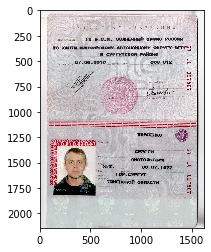

In [492]:
image = cv2.imread('test/225.jpeg')
image = rotate_passport(image)
image = cut_passport(image)

output = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(output)

In [491]:
def cut_passport(image):
    
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (1, 1), 0)
    edged = cv2.Canny(gray, 75, 200)

    rectKernel = cv2.getStructuringElement(cv2.MORPH_RECT, (50, 50))
    edged = cv2.morphologyEx(edged, cv2.MORPH_CLOSE, rectKernel)
    
    cnts = cv2.findContours(edged.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    cnts = sorted(cnts, key = cv2.contourArea, reverse = True)[:5]
    hullImage = np.zeros(gray.shape[:2], dtype="uint8")
    
    max_area = 0
    for (i, c) in enumerate(cnts):

        area = cv2.contourArea(c)

        if area > max_area:

            max_area = area

            (x, y, w, h) = cv2.boundingRect(c)

            aspectRatio = w / float(h)

            extent = area / float(w * h)

            hull = cv2.convexHull(c)
            hullArea = cv2.contourArea(hull)

            solidity = area / float(hullArea)


            output = image.copy()
            cv2.drawContours(output, [c], -1, (240, 0, 159), 3)


    cv2.drawContours(hullImage, [hull], -1, 255, -1)
    masked = cv2.bitwise_and(image, image, mask=hullImage)
    croped = get_segment_crop(image, mask=hullImage)
    croped = skew_text_correction(croped)
    
    return croped

In [467]:
def get_segment_crop(img,tol=0, mask=None):
    if mask is None:
        mask = img > tol
    return img[np.ix_(mask.any(1), mask.any(0))]

In [468]:
croped = get_segment_crop(image, mask=hullImage)

In [470]:
def skew_text_correction(image):
    
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.bitwise_not(gray)
    
    thresh = cv2.threshold(gray, 0, 255,
                cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]

    """
    cv2.imshow('Thresh', thresh)
    cv2.waitKey(0)
    """
    
    coords = np.column_stack(np.where(thresh > 0))
    angle = cv2.minAreaRect(coords)[-1]
    
    if angle < -45:
        angle = -(90 + angle)

    else:
        angle = -angle
    
    print(angle)
    
    (h, w) = image.shape[:2]
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    rotated = cv2.warpAffine(image, M, (w, h),
                flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)
       
    
    """
    cv2.imshow("Input", image)
    cv2.imshow("Rotated", rotated)
    cv2.waitKey(0)
    """
    
    return rotated

In [471]:
croped = skew_text_correction(croped)

-4.116462707519531


In [472]:
"""
cv2.imshow('Croped', croped)
cv2.imshow('Original', image)
cv2.waitKey(0)
cv2.destroyAllWindows()
"""

"\ncv2.imshow('Croped', croped)\ncv2.imshow('Original', image)\ncv2.waitKey(0)\ncv2.destroyAllWindows()\n"

In [473]:
image = croped

In [474]:
(h, w, _) = image.shape
top = image[0:int(h/2), 0:w]
bottom = image[int(h/2 + h/20):int(h-h/4),int(w/3):w]

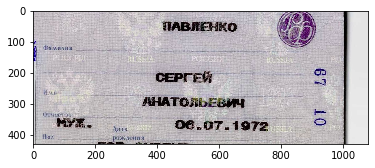

In [475]:
plt.imshow(bottom, cmap='gray')

In [476]:
def parse_name(full_name):
    return None

In [480]:
def find_person_name(ROI):
    
    bottom = ROI.copy()
    
    gray = cv2.cvtColor(bottom, cv2.COLOR_BGR2GRAY)
    edged = cv2.Canny(gray, 75, 200)
    
    rectKernel = cv2.getStructuringElement(cv2.MORPH_RECT, (25, 5))
    edged = cv2.morphologyEx(edged, cv2.MORPH_CLOSE, rectKernel)

    edged = cv2.erode(edged, (25, 25), iterations=2)
    edged = cv2.dilate(edged, (25, 25), iterations=2)
    
    cnts = cv2.findContours(edged.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    cnts = contours.sort_contours(cnts,
                        method="top-to-bottom")[0]
    hullImage = np.zeros(gray.shape[:2], dtype="uint8")
    
    full_name = []
    for (i, c) in enumerate(cnts):
        (x, y, w, h) = cv2.boundingRect(c)
        ar = w / h

        if w > 100 and h > 100 and ar > 2.5:

            output = bottom.copy()
            
            full_name.append(image_to_string(output[y:y+h,x:x+w], lang='rus').replace('\n', ' '))
            print(image_to_string(output[y:y+h,x:x+w], lang='rus').replace('\n', ' '))
            
            
    result = []
    result.append([re.sub(r'[^а-яА-Я]+', '', f) for f in full_name if f != ''][:3])
    result.append(full_name)
    return result
    
    
    """
    if len(full_name) >= 3:
        print(full_name)
        result = []
        result.append([re.sub(r'[^а-яА-Я]+', '', f) for f in full_name if f != ''][:3])
        result.append(full_name)
        return result
    
    else:
        full_name = image_to_string(bottom, lang='rus')
        return full_name
    """

In [481]:
full_name = find_person_name(bottom)

In [482]:
full_name

[[], ['']]

In [483]:
full_name = image_to_string(bottom, lang='rus')

In [484]:
full_name

'/\nФамилия\n|\n\nи\n\nПАВЛЕНКО\n\nСЕРГЕЙ\nАНАТОЛЬЕВИЧ\nАата ое = От = 1 972\n\nрождения\nыы\n\n \n\n19'

In [485]:
def read_text_from_box(image, startX, startY, endX, endY):
    
    box = image[startY:endY, startX: endX]
    
    """
    cv2.imshow('ROI', box)
    cv2.waitKey(0)
    """
    
    box = cv2.resize(box, None, fx=2, fy=2, interpolation=cv2.INTER_CUBIC)

    gray = cv2.cvtColor(box.copy(), cv2.COLOR_BGR2GRAY)

    blurred = cv2.medianBlur(gray, 1)
    thresh = cv2.threshold(blurred.copy(), 0, 225,
                           cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]

    return image_to_string(thresh, lang='rus').replace('\n', ' ')

In [486]:
def read_passport_number(image, show_steps=False):
    """
    Function for reading passport numbers by finding red zones
    :image: np.array
    :show_steps: bool
    :rtype: string
    """
    
    # Rotating the image
    image = imutils.rotate_bound(image, -90)

    if show_steps:
        cv2.imshow('Bottom', image)
        cv2.waitKey(0)

    
    # Creaing and aplying red mask on the image
    img_hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    lower_red = np.array([0,50,50])
    upper_red = np.array([10,255,255])
    mask = cv2.inRange(img_hsv, lower_red, upper_red)
    masked = cv2.bitwise_and(image, image, mask=mask)
    
    if show_steps:
        cv2.imshow('Masked', masked)
        cv2.waitKey(0)
        
    
    # Deleting tresh
    kernel = np.ones((5, 5), np.uint8)
    masked = cv2.dilate(masked, kernel, iterations=3)
    
    if show_steps:
        cv2.imshow('Dilate', masked)
        cv2.waitKey(0)
    
    
    # Closing gaps betweeen letters
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (30, 30))
    closed = cv2.morphologyEx(masked, cv2.MORPH_CLOSE, kernel)
    
    if show_steps:
        cv2.imshow('Closed', closed)
        cv2.waitKey(0)
        
    
    # Finding image contours
    closed = cv2.cvtColor(closed, cv2.COLOR_HSV2BGR)
    closed = cv2.cvtColor(closed, cv2.COLOR_BGR2GRAY)

    cnts = cv2.findContours(closed.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    cnts = contours.sort_contours(cnts,
                    method="top-to-bottom")[0]
    
    # Reading text from bounding boxes
    number = ''
    for c in cnts:
        (gX, gY, gW, gH) = cv2.boundingRect(c)
        cv2.rectangle(image, (gX - 5, gY - 5),
                    (gX + gW + 5, gY + gH + 5), (0, 0, 255), 2)
        
        if show_steps:
            cv2.imshow('ROI', image)
            cv2.waitKey(0)

        number += read_text_from_box(image, gX, gY, gX + gW, gY + gH)
        
    return number

In [487]:
read_passport_number(croped)

'м027507кипучоии\\ он кенни\\/х иаянни\\кинэ\\ жоф 218КИЕ:сз  ИИА ЖОЦ ооам,  ОИ  м  Э.Н}      [357 Ре 59 КИМ В) ВД $) С а  $ Сино жоа олоау:  оиОСнеаа Чонеия вле'

In [19]:
"""
cv2.imshow('Top', top)
cv2.imshow('Bottom', bottom)
cv2.waitKey(0)
cv2.destroyAllWindows()
"""

In [488]:
image_to_string(bottom, lang='rus')

'/\nФамилия\n|\n\nи\n\nПАВЛЕНКО\n\nСЕРГЕЙ\nАНАТОЛЬЕВИЧ\nАата ое = От = 1 972\n\nрождения\nыы\n\n \n\n19'

In [30]:
gray = cv2.cvtColor(bottom, cv2.COLOR_BGR2GRAY)
edged = cv2.Canny(gray, 75, 200)

In [22]:
cv2.imshow('Edged', edged)
cv2.waitKey(0)

-1

In [31]:
rectKernel = cv2.getStructuringElement(cv2.MORPH_RECT, (25, 25))
edged = cv2.morphologyEx(edged, cv2.MORPH_CLOSE, rectKernel)

In [24]:
cv2.imshow('Edged', edged)
cv2.waitKey(0)

-1

In [32]:
edged = cv2.erode(edged, (25, 25), iterations=3)
edged = cv2.dilate(edged, (25, 25), iterations=3)

In [33]:
cnts = cv2.findContours(edged.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
cnts = contours.sort_contours(cnts,
                    method="top-to-bottom")[0]
hullImage = np.zeros(gray.shape[:2], dtype="uint8")

In [34]:
print(len(cnts))

24


In [35]:
full_name = []
for (i, c) in enumerate(cnts):
    (x, y, w, h) = cv2.boundingRect(c)
    ar = w / h
    
    if w > 20 and h > 20 and ar > 2.5:

        output = bottom.copy()

        cv2.rectangle(output, (x - 5, y - 5),
                    (x + w + 5, y + h + 5), (0, 0, 255), 2)
        
        full_name.append(image_to_string(output[y-5:y+h+5,x-5:x+w+5], lang='rus'))
        
        """
        cv2.imshow('Output', output)
        cv2.waitKey(0)
        """

In [36]:
full_name = [re.sub(r'[^А-Я]+', '', f) for f in full_name][:3]

In [37]:
full_name

['ГИНДУЛЛИНА', 'НАТАЛЬЯ', 'ГЕННАДИЕВНА']

In [49]:
cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL,
            cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
cnts = contours.sort_contours(cnts,
                method="top-to-bottom")[0]
locs = []

for (i, c) in enumerate(cnts):
    (x, y, w, h) = cv2.boundingRect(c)
    ar = w / float(h)

    if w > 10 and h > 10:
        locs.append((x, y, w, h))

        cv2.rectangle(image, (x - 5, y - 5),
                             (x + w + 5, y + h + 5), (0, 0, 255), 2)

        cv2.imshow('ROI', image)
        cv2.waitKey(0)


In [72]:
def locate_text(image, type_):
    
    image = image.copy()
    
    if type_ == 'top':
        rectKernel = cv2.getStructuringElement(cv2.MORPH_RECT, (20, 3))
    elif type_ == 'bottom' or type_ == 'number':
        rectKernel = cv2.getStructuringElement(cv2.MORPH_RECT, (15, 5))
        
    sqKernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 2))
    
    #image = imutils.resize(image, width=300)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (5, 5), 0)
    tophat = cv2.morphologyEx(gray, cv2.MORPH_BLACKHAT, rectKernel)
    
    """
    cv2.imshow('Tophat', tophat)
    cv2.waitKey(0)
    
    
    gradX = cv2.Sobel(tophat, ddepth=cv2.CV_32F, dx=1, dy=0,
                    ksize=-1)
    gradX = np.absolute(gradX)
    (minVal, maxVal) = (np.min(gradX), np.max(gradX))
    gradX = (255 * ((gradX - minVal) / (maxVal - minVal)))
    gradX = gradX.astype("uint8")
    
    
    cv2.imshow('Gradient', gradX)
    cv2.waitKey(0)
    """ 
    
    #gradX = cv2.morphologyEx(gradX, cv2.MORPH_CLOSE, rectKernel)
    thresh = cv2.threshold(tophat, 0, 255,
                cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
    
    kernel = np.ones((5,5),np.uint8)
    thresh = cv2.erode(thresh, kernel, iterations = 2)
    thresh = cv2.dilate(thresh, kernel, iterations = 2)
    thresh = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, sqKernel)
    
    p = int(image.shape[1] * 0.05)
    thresh[:, 0:p] = 0
    thresh[:, image.shape[1] - p:] = 0

    
    cv2.imshow('Thresh', thresh)
    cv2.waitKey(0)
    
    
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL,
                cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    cnts = contours.sort_contours(cnts,
                    method="top-to-bottom")[0]
    locs = []
    
    for (i, c) in enumerate(cnts):
        (x, y, w, h) = cv2.boundingRect(c)
        ar = w / float(h)
        
        if type_ != 'number':
            if w > 10 and h > 10 and ar > 2.5:
                locs.append((x, y, w, h))
        else:
            if w > 10 and h > 10:
                locs.append((x, y, w, h))

    locs = sorted(locs, key=lambda x:x[0])
    
    output = []
    text = ''
    
    (h, w, _) = image.shape
    
    
    for (i, (gX, gY, gW, gH)) in enumerate(locs):
        groupOutput = []
 

        group = gray[gY - 5:gY + gH + 5, gX - 5:gX + gW + 5]
        group = cv2.threshold(group, 0, 255,
                    cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
 
        cv2.rectangle(image, (gX - 5, gY - 5),
                        (gX + gW + 5, gY + gH + 5), (0, 0, 255), 2)
        
        
        cv2.imshow('ROI', image)
        cv2.waitKey(0)
        
        
    return text

In [73]:
locs = locate_text(bottom, type_='bottom')

ValueError: not enough values to unpack (expected 2, got 0)

In [53]:
full_name = []

for i in range(3):
    (gX, gY, gW, gH) = locs[i]
    
    text = read_text_from_box(image, gX - 5, gY - 5,
                           gX + gW + 5, gY + gH + 5)
            
    text = re.sub(r'[^а-яА-Я]+', '', text)
            
    full_name.append(text)

IndexError: string index out of range

In [54]:
full_name

[]

In [456]:
number = read_passport_number(croped)

NameError: name 'read_text_from_box' is not defined

In [130]:
passport = {
    'ocr_result': {
        'doc_type': 'passport',
        'issue_authority': '',
        'issue_code': '',
        'issue_date': '',
        'surname': '',
        'name': '',
        'patronymic_name': '',
        'birth_date': '',
        'gender': '',
        'birth_place': '',
        'series': '',
        'number': '',
    },
    'text': '',
}

In [131]:
# Looking for passport series

series = re.search(r'(\d{2} {1,3}\d{2})', number)
if series is not None:
    passport['ocr_result']['series'] = series[0]
    
# Looking for passport number

num = re.search(r'(\d{6})', number)
if num is not None:
    passport['ocr_result']['number'] = num[0]

In [119]:
rectKernel = cv2.getStructuringElement(cv2.MORPH_RECT, (300, 300))

gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
gray = cv2.GaussianBlur(gray, (5, 5), 0)
tophat = cv2.morphologyEx(gray, cv2.MORPH_BLACKHAT, rectKernel)

In [120]:
gradX = cv2.Sobel(tophat, ddepth=cv2.CV_32F, dx=1, dy=0,
                ksize=-1)
gradX = np.absolute(gradX)
(minVal, maxVal) = (np.min(gradX), np.max(gradX))
gradX = (255 * ((gradX - minVal) / (maxVal - minVal)))
gradX = gradX.astype("uint8")

In [121]:
rectKernel = cv2.getStructuringElement(cv2.MORPH_RECT, (150, 150))
sqKernel = cv2.getStructuringElement(cv2.MORPH_RECT, (25, 25))

gradX = cv2.morphologyEx(gradX, cv2.MORPH_CLOSE, rectKernel)
thresh = cv2.threshold(gradX, 0, 255,
            cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]

thresh = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, sqKernel)


In [122]:
masked = cv2.bitwise_and(image, image, mask=thresh)
cv2.imshow('Masked', masked)
cv2.waitKey(0)

-1

In [123]:
gray = cv2.cvtColor(masked, cv2.COLOR_BGR2GRAY)

cnts = cv2.findContours(gray.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
hullImage = np.zeros(gray.shape[:2], dtype="uint8")

In [124]:
max_area = 0
for (i, c) in enumerate(cnts):
    area = cv2.contourArea(c)
    
    if area > max_area:
        
        max_area = area
        
        (x, y, w, h) = cv2.boundingRect(c)

        aspectRatio = w / float(h)

        extent = area / float(w * h)

        hull = cv2.convexHull(c)
        hullArea = cv2.contourArea(hull)

        solidity = area / float(hullArea)
        
        output = image.copy()
        cv2.drawContours(output, [c], -1, (240, 0, 159), 3)
        cv2.imshow('Output', output)
        cv2.waitKey(0)

        
cv2.drawContours(hullImage, [hull], -1, 255, -1)
#cv2.drawContours(image, [c], -1, (240, 0, 159), 3)


cv2.imshow("Convex Hull", resize(hullImage, width=750))
cv2.imshow("Image", resize(image, width=750))
cv2.waitKey(0)

-1

In [125]:
image = resize(image, width=750)
hullImage = resize(hullImage, width=750)

masked = cv2.bitwise_and(image, image, mask=hullImage)
cv2.imshow('Masked', masked)
cv2.waitKey(0)

-1

In [43]:
cv2.imshow('Gradient', gradX)
cv2.waitKey(0)

-1

-1

In [40]:
cv2.imshow('Thresh', resize(thresh.copy(), width=750))
cv2.imshow('Input', resize(image.copy(), width=750))
cv2.waitKey(0)
cv2.destroyAllWindows()